In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Content
- [Super class for regression models](#Super-class-for-regression-models)
- [Generating the data](#Generating-the-data)
- [1. Linear regression with normal equation](#1.-Linear-regression-with-normal-equation)
- [2. Batch gradient descent](#2.-Batch-gradient-descent)
- [3. Stochastic gradient descent](#3.-Stochastic-gradient-descent)

# Super class for regression models

In [2]:
def r2(y, y_hat):
    SS_tot = np.sum(np.square(y - y.mean()))
    SS_res = np.sum(np.square(y_hat - y.mean()))
        
    r2_score = SS_res / SS_tot
    return r2_score


class Regressor():
    '''Base class for regression'''
    def __init__(self):
        pass
    
    def predict(self):
        pass
    
    def fit(self):
        pass
    
    def score(self, X, y):
        y_hat = self.predict(X)
        
        r2_score = r2(y, y_hat)
        return r2_score

# Generating the data
$$
y = X \beta
$$
with
$$
\beta = \begin{bmatrix}
4\\
3\\
\end{bmatrix}
$$

$x$ is the instance feature vector containing $x_0$ to $x_n$ where $x_0$ is always equal to 1 (the bias term).

In [63]:
np.random.seed(314159265)

beta = np.array([[4], [3]])

X = 2 * np.random.rand(1000, beta.size - 1)
# adding x_0 = 1 for all instances
X_b = np.c_[np.ones((X.shape[0], 1)), X]

# adding a random error
y = X_b.dot(beta) + np.random.normal(0, 0.25, (X.shape[0], 1))

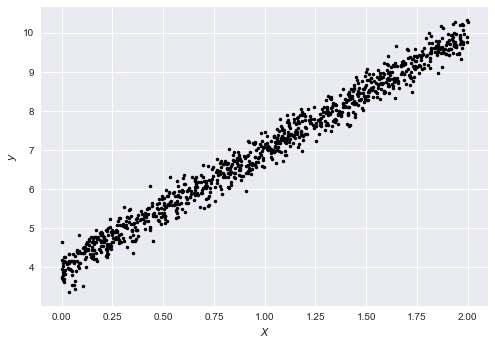

In [68]:
plt.plot(X, y, 'k.')
plt.xlabel(r'$X$')
plt.ylabel(r'$y$');

<a id=’test’></a>
# 1. Linear regression with normal equation
$$
\hat{y} = X \beta
$$
We try to minimize the residual sum of squares,

$$
R(\beta)=\sum_{i=1}^N (y_i - x^T_i \beta)^2 = (y-X\beta)^T(y-X\beta) = (y^T-\beta^TX)(y-X\beta) \\ 
= y^Ty - y^TX\beta - \beta^TX^Ty + \beta^TX^TX\beta
$$


Note that, 

$$
(y^TX\beta)^T = \beta^TX^Ty
$$


Differntiate with respect to $\beta$ and set equal to 0,

$$
\frac{\partial R}{\partial\beta} = 0 - X^Ty - X^Ty + 2X^TX\beta = -2X^T(y-X\beta) = 0 \\
= X^T(y - X\beta)=0
$$

$$
\therefore \beta = (X^T X)^{-1} X^Ty
$$

This is called the normal equation from which we can estimate $\beta$.

In [20]:
class LinearRegression(Regressor):
    '''Linear regression estimation by normal equation'''
    def __init__(self):
        self.beta = None

    def fit(self, X, y):
        # adding x_0 = 1 for all instances
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        # esitmating beta with the normal equation
        beta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        self.beta = beta
    
    def predict(self, X):
        # adding x_0 = 1 for all instances
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        # predicting y_hat
        y_hat = X_b.dot(self.beta)
        return y_hat

In [65]:
reg = LinearRegression()
reg.fit(X, y)
reg.score(X, y)

0.9804111490810594

In [66]:
reg.beta

array([[4.00880038],
       [2.99295502]])

# 2. Batch gradient descent
For a gradient descent we use a loss/error function that we try to minimize by using the gradient (slope of the error). The gradient descent in this case is based on the mean squared error ($\mathrm{MSE}$).
$$
\mathrm{MSE} = \frac{1}{n}\sum_{i=1}^{n} (x^T_i \beta - y_i)^2
$$
The parial derivative with regard to $\beta$ results in:
$$
\frac{\partial}{\partial\beta}\mathrm{MSE} = \frac{2}{n}\sum_{i=1}^{n} x^T_i (x^T_i \beta - y_i)
$$

$$
\nabla_\beta \mathrm{MSE} = \frac{2}{n}X^T(X\beta - y)
$$
For batch gradient descent we use the entire X matrix to determine the gradient of the loss function. Also a sample can be used to estimate this gradient which is significantly faster but less accurate (see SGDRegressor and miniBGDRegressor).

In [29]:
class BGDRegressor(Regressor):
    '''Linear regression learning with Batch Gradient Descent based on the mean squared error'''
    def __init__(self, n_iterations=1000, learning_rate=0.01, random_state=314159265):
        self.n_iterations = n_iterations
        self.eta = learning_rate
        self.random_state = random_state
        
        self.beta = None
        # saving history of beta
        self.betas = None
        
        # saving the history of mse
        self.mse = np.zeros(self.n_iterations)

        
    def fit(self, X, y):      
        # adding x_0 = 1 for all instances
        X_b = np.c_[np.ones((len(X), 1)), X]
        n = len(X)
        
        np.random.seed(self.random_state)
        
        # initiating beta with random values in [0, 1]
        self.beta = np.random.randn(X.shape[1] + 1, 1)
        # saving the history of beta
        self.betas = np.zeros((self.n_iterations, X.shape[1] + 1))
        
        for i in range(self.n_iterations):
            # determining mean squared error 
            self.mse[i] = np.square(X_b.dot(self.beta) - y).mean()
            # determining gradient 
            gradient = 2 / n * X_b.T.dot(X_b.dot(self.beta) - y)
            
            # moving beta towards the opposite direction of gradient
            self.beta -= self.eta * gradient
            # adding beta to history of betas
            self.betas[i] = self.beta.ravel()
                                    
    
    def predict(self, X):       
        X_b = np.c_[np.ones((len(X), 1)), X]
        return X_b.dot(self.beta)

In [70]:
bgd = BGDRegressor(
    n_iterations=1000, 
    learning_rate=0.01
)

bgd.fit(X, y)
bgd.beta

array([[3.9602383 ],
       [3.03444502]])

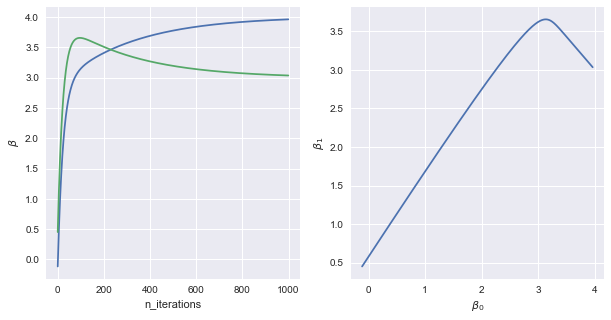

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(bgd.betas)
ax[0].set_xlabel('n_iterations')
ax[0].set_ylabel(r'$\beta$')

ax[1].plot(*bgd.betas.T)
ax[1].set_xlabel(r'$\beta_0$')
ax[1].set_ylabel(r'$\beta_1$');

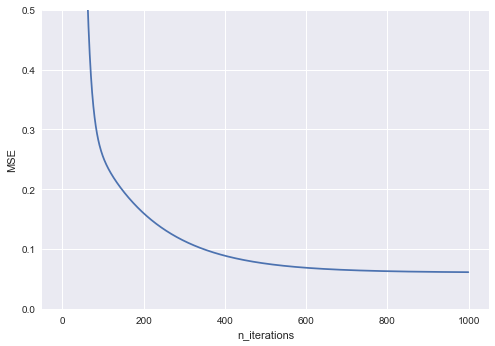

In [72]:
plt.plot(bgd.mse)
plt.xlabel('n_iterations')
plt.ylabel('MSE')
plt.ylim(0, 0.5);

# 3. Stochastic gradient descent
Stochastic gradient descent is based on batch gradient descent. However, stochastic descent only samples one instance to drastically improve speed.

In [89]:
class SGDRegressor(Regressor):
    '''Linear regression learning with Stochastic Gradient Descent based on the mean squared error'''
    def __init__(self, n_iterations=1000, n_epochs=5, learning_rate=0.001, random_state=314159265):
        self.n_iterations = n_iterations
        self.n_epochs = n_epochs
        self.eta = learning_rate
        self.random_state = random_state
        
        self.theta = None
        # saving history of theta
        self.thetas = None
                
        # saving the history of mse
        self.mse = np.zeros(self.n_iterations * self.n_epochs)
        
        
    def fit(self, X, y):
        # adding x_0 = 1 for all instances
        X_b = np.c_[np.ones((len(X), 1)), X]
        n = len(X)
        
        np.random.seed(self.random_state)
        
        # initiating theta with random values in [0, 1]
        self.theta = np.random.randn(X.shape[1] + 1, 1)
        # saving history of thetas
        self.thetas = np.zeros((self.n_epochs * self.n_iterations, X_b.shape[1]))
        
        # index for saving mse and thetas
        i = 0
        for _ in range(self.n_epochs):
            for _ in range(self.n_iterations):
                # determining mean squared error
                self.mse[i] = np.square(X_b.dot(self.theta) - y).mean()
                
                # random sampling an instance
                index = np.random.randint(n)
                Xi = X_b[index:index+1]
                yi = y[index:index+1]
                
                # determining the gradient
                gradient = 2 * Xi.T.dot(Xi.dot(self.theta) - yi)
                
                # moving theta towards the opposite direction of gradient
                self.theta -= self.eta * gradient
                # adding theta to history of betas
                self.thetas[i] = self.theta.T
                i += 1
                      
                    
    def predict(self, X):       
        X_b = np.c_[np.ones((len(X), 1)), X]
        return X_b.dot(self.theta)

In [94]:
sgd = SGDRegressor(
    n_iterations=1000,
    n_epochs=3,
    learning_rate=0.01
)

sgd.fit(X, y)
sgd.theta

array([[3.9790598 ],
       [2.96740772]])

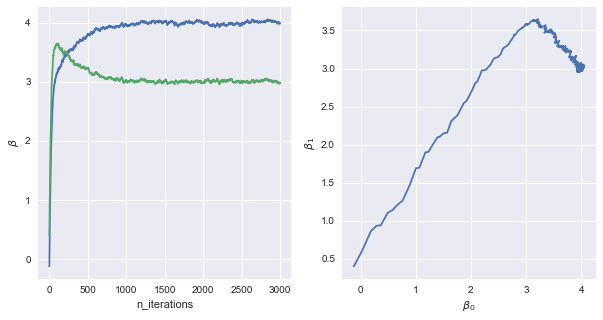

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(sgd.thetas)
ax[0].set_xlabel('n_iterations')
ax[0].set_ylabel(r'$\beta$')

ax[1].plot(*sgd.thetas.T)
ax[1].set_xlabel(r'$\beta_0$')
ax[1].set_ylabel(r'$\beta_1$');

# Mini-Batch Gradient Descent
The mini-batch gradient descent is like the stochastic gradient descent but with mutiple random samples called a mini-batch.

In [88]:
class miniBGDRegressor(Regressor):
    '''Linear regression learning with Stochastic Gradient Descent based on the mean squared error'''
    def __init__(self, batch_size=10, n_epochs=50, learning_rate=0.1, random_state=3141):
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.eta = learning_rate
        self.random_state = random_state
        
        self.theta = None
        self.thetas = None
               
        # saving the history of mse
        self.mse = None
               
        
    def fit(self, X, y):
        # adding x_0 = 1 for all instances
        X_b = np.c_[np.ones((len(X), 1)), X]
        n = len(X)
        
        np.random.seed(self.random_state)
        
        # initiating theta with random values in [0, 1]
        self.theta = np.random.randn(X.shape[1] + 1, 1)
        # saving history of thetas
        self.thetas = np.zeros((self.mse.size, X_b.shape[1]))
        
        # saving history of mse
        self.mse = np.zeros(int(np.ceil(n / self.batch_size) * self.n_epochs))
             
        # index for saving mse and thetas
        i = 0
        for epoch in range(self.n_epochs):
            # random shuffling the dataset
            shuffled_index = np.arange(n)
            np.random.shuffle(shuffled_index)
            X_b_s = X_b[shuffled_index]
            y_s = y[shuffled_index]
            
            # splitting the shuffled dataset in mini-batches            
            for index in range(0, n, self.batch_size):
                # determining mean squared error
                self.mse[i] = np.square(X_b.dot(self.theta) - y).mean()
                
                # getting the mini-batch
                Xi = X_b_s[index: index + self.batch_size]
                yi = y_s[index: index + self.batch_size]
                
                # estimating the gradient
                gradient = 2 / self.batch_size * Xi.T.dot(Xi.dot(self.theta) - yi)
                
                # moving theta towards the opposite direction of gradient
                self.theta -= self.eta * gradient
                # adding theta to history of thetas
                self.thetas[i] = self.theta.T
                i += 1
                                    
    
    def predict(self, X):
        # adding x_0 = 1 for all instances
        X_b = np.c_[np.ones((len(X), 1)), X]
        return X_b.dot(self.theta)

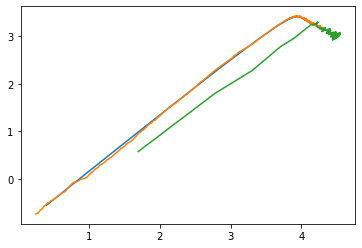

In [523]:
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.rand(100, 1)

bgd = BGDRegressor()
sgd = SGDRegressor()
sgdb = SGDRegressorBatch()

for m in [bgd, sgd, sgdb]:
    m.fit(X, y)
    plt.plot(*m.thetas.T)

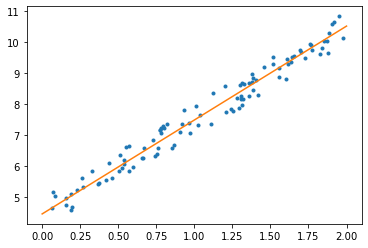

In [520]:
reg.fit(X, y)
reg.theta

plt.plot(X, y, '.')
plt.plot([0, 2], np.array([[1, 0], [1,2]]).dot(reg.theta));